# 1. Preprocessing - Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Using cached scipy-1.9.1-cp39-cp39-win_amd64.whl (38.6 MB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\adabd\AppData\Local\Temp\pip-install-19k7ez7m\tensorflow-gpu_1ee85b33be754457a2ab5df0435c6053\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-e

In [2]:
# !pip install --upgrade pip
!pip install tensorflow

  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [3]:
# importing libraries
import os
import cv2


## 1.2 Annotate Images with LabelMe

In [4]:
# !pip install labelme  

In [5]:
!labelme 

## 1.3 Build Image Loading Function

In [2]:
# importing libraries

import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [18]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
# Load Image into Tensorflow Data Pipeline
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

## 1.4 Partition Unaugmented Data - manually

In [1]:
264*.7 #185 move to train folder

184.79999999999998

In [ ]:
264*.15 # 33 to test and 21 to val

## 1.5 Rename file names

In [ ]:
# Rename files with multiple '.' in their names
for folder in ['test','train']: # for images folder
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')
            # Check if the file name has more than 2 parts separated by '.'
        if len(filename) > 2:
            newFilename = filename[0]+filename[1]+'.jpg'
            # Rename the file with the new name
            os.renames('data/'+folder+'/images/'+file,'data/'+folder+'/images/'+newFilename)

            # Rename the corresponding label files with the same naming convention as the images
for folder in ['test','train','val']: # for labels folder
    for file in os.listdir(os.path.join('data','labels')):        
        filename = file.split('.')
        # Check if the file name has more than 2 parts separated by '.'
        if len(filename) > 2:
            newFilename = filename[0]+filename[1]+'.json'
            # Rename the file with the new name
            os.renames('data/labels/'+file,'data/labels/'+newFilename)
            
      

## 1.6 Move the Images and Matching Labels

In [ ]:
# Splitting and Moving the Images and Matching Labels into 'train','test','val' folders
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)    

## 1.7 Apply Image Augmentation on Images and Labels using Albumentations

In [27]:
# setting up pipeline
!pip install albumentations

In [28]:
import albumentations as alb

In [29]:
# Initialising albumentations library to artificially augment dataset
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))


### 1.7.1 Testing augmentation pipeline

#### 1.7.1.1 Load a Test Image and Annotation with OpenCV and JSON

In [154]:
img = cv2.imread(os.path.join('data', 'train', 'images', '01croplabeled.jpg'))

In [155]:
with open(os.path.join('data', 'train', 'labels', '01croplabeled.json'), 'r') as f:
    label = json.load(f)


In [156]:
label['shapes'][0]['points']

[[59.690721649484516, 87.42268041237114],
 [417.42268041237116, 416.2886597938144]]

In [157]:
img.shape

(480, 640, 3)

#### 1.7.1.2 Extract Coordinates and Rescale to Match Image Resolution

In [159]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [160]:
coords

[59.690721649484516, 87.42268041237114, 417.42268041237116, 416.2886597938144]

In [161]:
coords = list(np.divide(coords, [640,480,640,480]))

In [162]:
coords

[0.09326675257731956,
 0.18213058419243985,
 0.65222293814433,
 0.8672680412371133]

#### 1.7.1.3 Apply Augmentations and View Results

In [164]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['braille'])

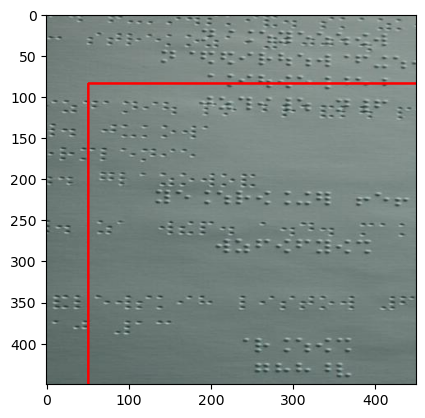

In [168]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [650,650]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [650,650]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### 1.7.2 Build and Run Augmentation Pipeline

#### 1.7.2.1 Run Augmentation Pipeline

In [171]:
# This loop iterates through each image in the current partition
for image in os.listdir(os.path.join('data', partition, 'images')):

    # Read the image using cv2
    img = cv2.imread(os.path.join('data', partition, 'images', image))

    # Initialize coords with default values
    coords = [0,0,0.00001,0.00001]

    # Get the path for the corresponding label file
    label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')

    # If the label file exists, read its content and update the coords list with the corresponding coordinates
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)

        coords[0] = label['shapes'][0]['points'][0][0]
        coords[1] = label['shapes'][0]['points'][0][1]
        coords[2] = label['shapes'][0]['points'][1][0]
        coords[3] = label['shapes'][0]['points'][1][1]

        # Normalize the coordinates by dividing them by the width and height of the image
        coords = list(np.divide(coords, [640,480,640,480]))

    # Try to apply data augmentation on the image 33 times
    try: 
        for x in range(33):
            # Apply data augmentation on the image and get the augmented image
            augmented = augmentor(image=img, bboxes=[coords], class_labels=['braille'])

            # Save the augmented image to the corresponding partition in the 'aug_data' directory
            cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

            # Create an annotation dictionary for the augmented image
            annotation = {}
            annotation['image'] = image

            # If the label file exists and the augmented image contains bounding boxes, update the annotation dictionary
            if os.path.exists(label_path):
                if len(augmented['bboxes']) == 0: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                else: 
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = 1
            else: 
                annotation['bbox'] = [0,0,0,0]
                annotation['class'] = 0 

            # Save the annotation dictionary to the corresponding partition in the 'aug_data' directory
            with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                json.dump(annotation, f)

    # If an exception is raised during the data augmentation process, print the exception message and the image name
    except Exception as e:
        print(e)
        print(image)


Requested crop size (450, 450) is larger than the image size (357, 480)
IMG_20190715_122812labeled.jpg
Requested crop size (450, 450) is larger than the image size (357, 480)
IMG_20190715_122826labeled.jpg


## 1.8 load augmented data

### 1.8.1 Load images and preprocess them for model input

In [6]:
# Load train images and preprocess them for model input
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)# Load image using custom function
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))# Resize images to (120,120)
train_images = train_images.map(lambda x: x/255) # Normalize pixel values to range [0,1]

In [7]:
# Load test images and preprocess them for model input
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)# Load image using custom function
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))# Resize images to (120,120)
test_images = test_images.map(lambda x: x/255) # Normalize pixel values to range [0,1]

In [8]:
# Load validation images and preprocess them for model input
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)  # Load image using custom function
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))  # Resize images to (120,120)
val_images = val_images.map(lambda x: x/255)  # Normalize pixel values to range [0,1]


In [9]:
# Create an iterator over the dataset by batching images into groups of 4 and converting them to numpy arrays
train_images.as_numpy_iterator().next()

array([[[0.9504902 , 0.93535537, 0.7656863 ],
        [0.9607843 , 0.94411767, 0.78088236],
        [0.9519608 , 0.9352941 , 0.7769608 ],
        ...,
        [0.98039216, 0.9764706 , 1.        ],
        [0.98039216, 0.9764706 , 1.        ],
        [0.98039216, 0.9764706 , 1.        ]],

       [[0.9759804 , 0.96844363, 0.8093137 ],
        [0.97990197, 0.972549  , 0.8102941 ],
        [0.9676471 , 0.9627451 , 0.7897059 ],
        ...,
        [0.98039216, 0.9764706 , 1.        ],
        [0.98039216, 0.9764706 , 1.        ],
        [0.98039216, 0.9764706 , 1.        ]],

       [[0.9893382 , 0.9814951 , 0.7898284 ],
        [0.98333335, 0.9754902 , 0.7872549 ],
        [0.97990197, 0.9642157 , 0.779902  ],
        ...,
        [0.97996324, 0.9760417 , 0.9995711 ],
        [0.97653186, 0.9726103 , 0.9961397 ],
        [0.98020834, 0.97628677, 0.9998162 ]],

       ...,

       [[0.9759804 , 0.97990197, 0.9995098 ],
        [0.9759804 , 0.97990197, 0.9995098 ],
        [0.97107846, 0

### 1.8.2 Load labels images and preprocess them for model input

In [10]:
# Build Label Loading Function
# define a function to load the labels from the json file
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    # return the class label and the bounding box coordinates
    return [label['class']], label['bbox']

In [11]:
# load train labels and map them to the label loading function
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
# load test labels and map them to the label loading function
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
# load val labels and map them to the label loading function
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

## 1.9 Combine Label and Image Samples

In [40]:
# Check Partition Lengths
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6560, 6561, 1287, 1287, 1287, 1287)

>>>> 1. Create Final Datasets (Images/Labels)

In [16]:
# Combine the images and labels into a single dataset
train = tf.data.Dataset.zip((train_images, train_labels)) 
train = train.shuffle(6500) #Shuffle the dataset with a buffer size of 6500
train = train.batch(8) # Batch the dataset with a batch size of 8
train = train.prefetch(4) # Prefetch the dataset with a buffer size of 4

In [17]:
val = tf.data.Dataset.zip((val_images, val_labels)) # Combine the images and labels into a single dataset
val = val.shuffle(2000) #Shuffle the dataset with a buffer size of 2000
val = val.batch(8) # Batch the dataset with a batch size of 8
val = val.prefetch(4) # Prefetch the dataset with a buffer size of 4

In [18]:
test = tf.data.Dataset.zip((test_images, test_labels))# Combine the images and labels into a single dataset
test = test.shuffle(2000) #Shuffle the dataset with a buffer size of 2000
test = test.batch(8) # Batch the dataset with a batch size of 8
test = test.prefetch(4) # Prefetch the dataset with a buffer size of 4

## 1.10 View Images and Annotations

In [288]:
data_samples = test.as_numpy_iterator()

In [289]:

res = data_samples.next()

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 'class'
Traceback (most recent call last):

  File "c:\Users\adabd\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "c:\Users\adabd\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "c:\Users\adabd\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "c:\Users\adabd\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\adabd\AppData\Local\Temp\ipykernel_11804\233515788.py", line 5, in load_labels
    return [label['class']], label['bbox']

KeyError: 'class'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


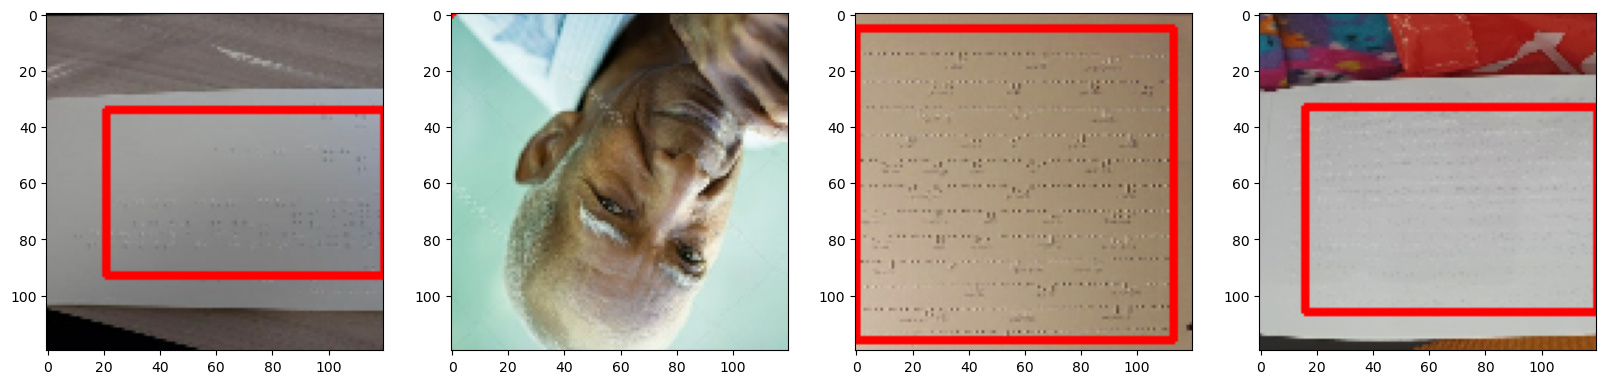

In [290]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 2.0 Prepaparing the model for Training

In [20]:
#Importing libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [21]:
# Creating an instance of the VGG16 model without the top layer
vgg = VGG16(include_top=False)

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 2.1 Build instance of Network

In [48]:
# Import necessary modules and classes
from tensorflow.keras.layers import Input, GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define a function to build the model
def build_model(): 
    # Define the input layer
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu', kernel_regularizer=l2(0.1))(f1)
    dropout_layer = Dropout(0.5)(class1)
    class2 = Dense(1, activation='sigmoid')(dropout_layer)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu', kernel_regularizer=l2(0.1))(f2)
    dropout_layer = Dropout(0.5)(regress1)
    regress2 = Dense(4, activation='sigmoid')(dropout_layer)
    
    brtracker = Model(inputs=input_layer, outputs=[class2, regress2])
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    brtracker.compile(loss=['binary_crossentropy', 'mse'], optimizer=opt)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    
    return brtracker, early_stop


## 2.2 Test out Neural Network

In [24]:
brailletracker, early_stop = build_model()
# model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stop])


In [25]:

brailletracker.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [26]:
brailletracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [28]:
#  retrieves the first batch of data from the train dataset as a tuple of two arrays X and y.
X, y = train.as_numpy_iterator().next()

In [29]:
# checking shape
X.shape

(8, 120, 120, 3)

In [30]:
# a rough prediction using pretrained vgg16 model
classes, coords = brailletracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [55]:
classes, coords

(array([[0.43766356],
        [0.39117122],
        [0.37298027],
        [0.4040198 ],
        [0.37462714],
        [0.43399024],
        [0.41019145],
        [0.40448704]], dtype=float32),
 array([[0.6040555 , 0.42448264, 0.3953037 , 0.38267627],
        [0.62863433, 0.45366296, 0.40978852, 0.41546074],
        [0.64473116, 0.43963578, 0.35105488, 0.42876774],
        [0.6996756 , 0.47826144, 0.35062948, 0.32995433],
        [0.6056697 , 0.319046  , 0.35416967, 0.4455704 ],
        [0.6542195 , 0.39671874, 0.35326317, 0.38399634],
        [0.6404418 , 0.45262203, 0.40678915, 0.3927141 ],
        [0.64910066, 0.3604607 , 0.34278268, 0.48009968]], dtype=float32))

## 2.3 Define Losses and Optimizers

>>>> Define Optimizer and Learning rate

In [55]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [56]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=lr_decay)

## 2.4 Create Localization Loss and Classification Loss

In [31]:
def localization_loss(y_true, yhat):
    # Calculate the difference in coordinates between predicted and actual bounding boxes
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    # Calculate the true height and width of the bounding boxes
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    # Calculate the predicted height and width of the bounding boxes
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    # Calculate the difference in size between predicted and actual bounding boxes
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    # Return the sum of the difference in coordinates and difference in size
    return delta_coord + delta_size


In [32]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

>>>>  Test out Loss Metrics

In [33]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.92848>

In [34]:

classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.76078284>

In [35]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.92848>

# 3.0 Train Neural Network

## 3.1 Create Custom Model Class

In [57]:
class Tracker(Model): # Define a custom model class that extends the Keras Model class
    
    def __init__(self, brailleTracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = brailleTracker # The brailleTracker model is set as an attribute of the custom Tracker model class

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss # Binary Cross-Entropy loss for classification
        self.lloss = localizationloss # Custom loss function for localization
        self.opt = opt # Optimizer to use for training
        self.train_acc = tf.keras.metrics.BinaryAccuracy() # Binary Accuracy metric to use for training
        self.test_acc = tf.keras.metrics.BinaryAccuracy() # Binary Accuracy metric to use for testing
    
    def train_step(self, batch, **kwargs): # Custom train step function
        
        X, y = batch # Extract the images and labels from the batch
        
        with tf.GradientTape() as tape: # Gradient tape context
            
            classes, coords = self.model(X, training=True) # Forward pass through the model to get predictions
            
            batch_classloss = self.closs(y[0], classes) # Calculate classification loss
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords) # Calculate localization loss
            
            total_loss = batch_localizationloss+0.5*batch_classloss # Total loss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables) # Compute gradients
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables)) # Update weights
        
        self.train_acc.update_state(y[0], classes) # Update binary accuracy metric
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss, "train_acc": self.train_acc.result()}
    
    def test_step(self, batch, **kwargs): # Custom test step function
        X, y = batch # Extract the images and labels from the batch
        
        classes, coords = self.model(X, training=False) # Forward pass through the model to get predictions
        
        batch_classloss = self.closs(y[0], classes) # Calculate classification loss
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords) # Calculate localization loss
        total_loss = batch_localizationloss+0.5*batch_classloss # Total loss
        
        self.test_acc.update_state(y[0], classes) # Update binary accuracy metric
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss, "test_acc": self.test_acc.result()}
        
    def call(self, X, **kwargs): # Custom call function
        return self.model(X, **kwargs) # Forward pass through the model to get predictions
    


In [58]:
model = Tracker(brailletracker) # Create an instance of the custom Tracker model class with the brailletracker model


In [59]:
model.compile(opt=opt, classloss=classloss, localizationloss=regressloss) # Compile the model with optimizer, classification loss, and localization loss.


## 3.2 Create callbacks

In [61]:
logdir='logs'

In [62]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## 3.3 Model Training

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_total_loss', patience=5) # Creates an EarlyStopping callback instance, which will stop the training if the validation loss doesn't improve for 5 epochs.

hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback, early_stop]) #Trains the Keras model


Epoch 1/50
 35/820 [>.............................] - ETA: 12:49 - total_loss: 5.4853 - class_loss: 0.5828 - regress_loss: 5.1939 - train_acc: 0.5945

In [56]:
# hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback,early_stop])
# hist = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stop])


# 4.0 Model evaluation

## 4.1 Plot Performance

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

# ax[3].plot(hist.history['train_acc'], color='teal', label='train acc')
# ax[3].plot(hist.history['val_test_acc'], color='orange', label='val_test_acc')
# ax[3].title.set_text('Accuracy')
# ax[3].legend()
plt.show()

: 

: 

In [ ]:
# fig, ax = plt.subplots(ncols=1, figsize=(20,5))

# ax[0].plot(hist.history['train_acc'], color='teal', label='train acc')
# ax[0].plot(hist.history['val_test_acc'], color='orange', label='val_test_acc')
# ax[0].title.set_text('Accuracy')
# plt.show()

## 4.2 Make Predictions

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat =brailletracker.predict(test_data)

160/160 [==============================] - 36s 226ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
yhat[0][1]

array([0.9999996], dtype=float32)

# 5.0 Saving the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
brailletracker.save('brailledetect5.h5')

In [3]:
brailletracker = load_model('brailledetect5.h5')

# 6.0 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = brailletracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Braille dot', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 7.0 Test the trained model

In [294]:
import cv2

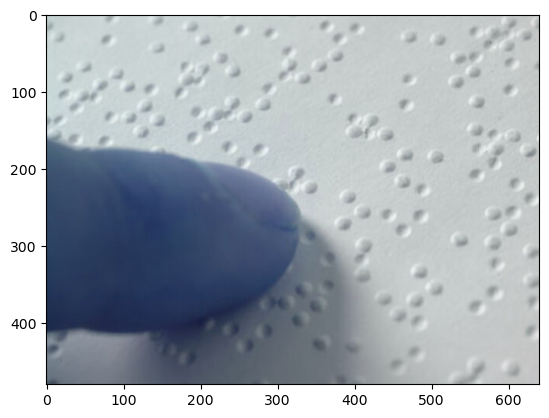

In [429]:
img = cv2.imread('data/zz bck/train/images/Braille_closeup.jpg')
plt.imshow(img)
plt.show()

In [ ]:
# 1 = 20230310_085757
# 2= 20230312_194859
# 3 = 20230320_154114
# 4 = 20230320_154136


import cv2
# img = cv2.imread('data/zz bck/train/images/20230310_085757.jpg')


img = cv2.imread('data/zz bck/train/images/Braille_closeup.jpg')

# get the current image dimensions
h, w, _ = img.shape

# # # Define the maximum size
max_size = 600

#  Determine the scale factor
scale_factor = max_size / max(h, w)

# Calculate the new size
new_height = int(h * scale_factor)
new_width = int(w * scale_factor)

# determine the resize parameters
resize_params = ((new_width, new_height) if w > h else (new_height, new_width ))

# resize the image using the determined parameters
resized_img = cv2.resize(img, resize_params)

yhat = brailletracker.predict(np.expand_dims(resized_img/255, 0))
sample_coords = yhat[1][0]

if yhat[0] < 0.6: 
    print(f'Predicted class is not braille')
else:
    print(f'Predicted class is braille')
    fig, ax = plt.subplots(ncols=1, figsize=(5,5))

    resize1 = resized_img.astype(int)

    # loop through all bounding boxes and draw a rectangle for each one
    for box in yhat[1]:
        cv2.rectangle(resize1, 
                      tuple(np.multiply(box[:2], resize_params).astype(int)),
                      tuple(np.multiply(box[2:], resize_params).astype(int)), 
                      (255,0,0), 2)

    cv2.rectangle(resize1, 
                  tuple(np.add(np.multiply(sample_coords[:2], resize_params).astype(int), 
                                [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[:2], resize_params).astype(int),
                                [80,0])), 
                  (255,0,0), -1)
        
    # Controls the text rendered
    cv2.putText(resize1, 'Braille', tuple(np.add(np.multiply(sample_coords[:2], resize_params).astype(int),
                                               [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, .7, (255,255,255), 1, cv2.LINE_AA)

    ax.imshow(resize1)

1/1 [==============================] - 0s 157ms/step
Predicted class is braille
probability value: [[0.9999985]]


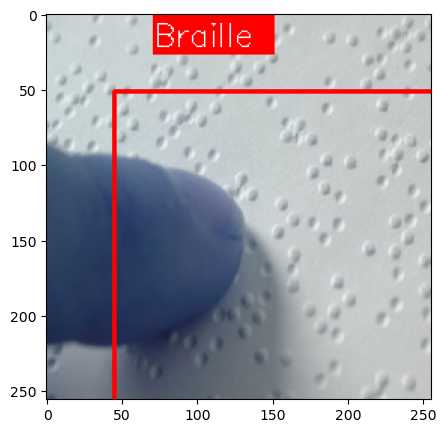

In [438]:
resize = tf.image.resize(img, (256,256))
# plt.imshow(resize.numpy().astype(int))
# plt.show()
yhat =brailletracker.predict(np.expand_dims(resize/255, 0))
# print('probability value:', yhat[0])
if yhat[0] < 0.6: 
    print(f'Predicted class is not braille')
else:
    print(f'Predicted class is braille')
    fig, ax = plt.subplots(ncols=1, figsize=(5,5))
    resize1 = resize.numpy().astype(int)
    cv2.rectangle(resize1, 
                        tuple(np.multiply(yhat[1][0][:2], [450,450]).astype(int)),
                        tuple(np.multiply(yhat[1][0][2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
    cv2.rectangle(resize1, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
    cv2.putText(resize1, 'Braille', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, .7, (255,255,255), 1, cv2.LINE_AA)
    ax.imshow(resize1)
print('probability value:', yhat[0])

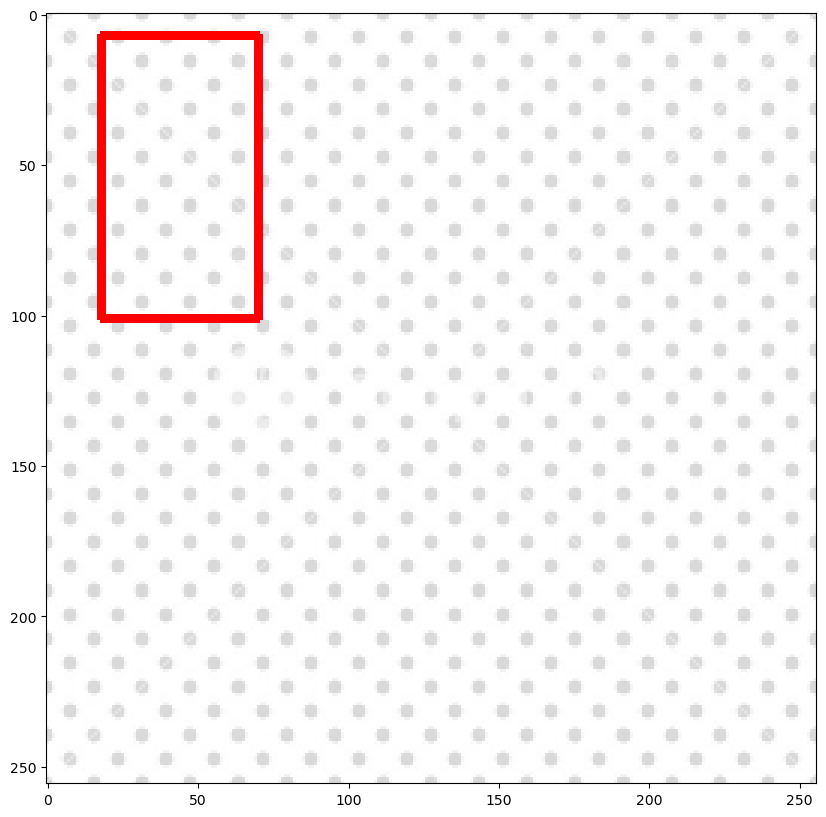

In [407]:
# yhat = model.predict(np.expand_dims(resize/255, 0))
fig, ax = plt.subplots( figsize=(10,10))
resize1 = resize.numpy().astype(int)
cv2.rectangle(resize1, 
                    tuple(np.multiply(yhat[1][0][:2], [120,120]).astype(int)),
                    tuple(np.multiply(yhat[1][0][2:], [120,120]).astype(int)), 
                        (255,0,0), 2)
ax.imshow(resize1)

In [323]:
yhat =brailletracker.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 157ms/step


In [384]:
yhat[1][0]

array([0.1578407 , 0.05881419, 0.5839735 , 0.8428874 ], dtype=float32)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(20,20))
if yhat[0] > -0.9:
        cv2.rectangle(resize, 
                      tuple(np.multiply(yhat[:2], [120,120]).astype(int)),
                      tuple(np.multiply(yhat[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
ax.imshow(resize)

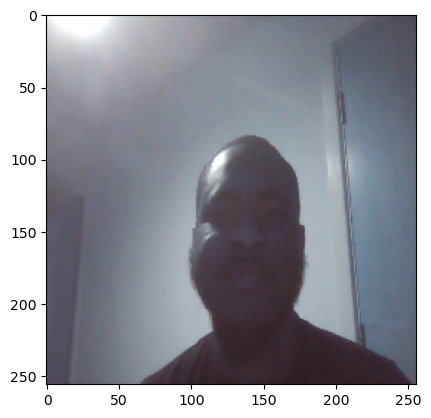

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [305]:



frame = 'data/zz bck/train/images/57aa5739-b923-11ed-9fdc-dde6729d35cd'
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120,120))

yhat = brailletracker.predict(np.expand_dims(resized/255,0))
sample_coords = yhat[1][0]

if yhat[0] > 0.5: 
    # Controls the main rectangle
    cv2.rectangle(frame, 
                    tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(frame, 
                    tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                [0,-30])),
                    tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                [80,0])), 
                        (255,0,0), -1)
    
    # Controls the text rendered
    cv2.putText(frame, 'Braille dot', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                            [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

# cv2.imshow('EyeTrack', frame)